# Exploring the effect of class imbalance on model performance

Starting with the Titanic dataset as a balanced one, we will make the training data more and more imbalanced to show the effects of trying to train with fewer and fewer positive samples.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from helpers import preprocessor_pipeline
from sklearn.model_selection import train_test_split

In [3]:
from helpers import CustomImputer

## Load data and split into train/val

In [4]:
train_df = pd.read_csv("data/train.csv")

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=1, stratify=train_df['Survived'])
train_df, val_df = (train_df.copy(), val_df.copy())

## Preprocessing the data

In [5]:
categorical_fts = ['Pclass', 'Embarked', "Sex"]
numerical_fts = ['Age', 'Fare']

input_features = numerical_fts + categorical_fts

In [6]:
preprocessor = preprocessor_pipeline(scaling=True)

In [7]:
train_tf = preprocessor.fit_transform(train_df[input_features])
train_y = train_df['Survived'].values

val_tf = preprocessor.transform(val_df[input_features])
val_y = val_df['Survived'].values

## Modelling

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
clf = RandomForestClassifier()

In [12]:
trained_model = clf.fit(train_tf, train_y)

## Validation

In [13]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score
)

In [14]:
scores = clf.predict_proba(val_tf)[:, 1]

In [15]:
y_hat = np.where(scores, 1, 0)

In [16]:
print(classification_report(val_y, y_hat))
print(confusion_matrix(val_y, y_hat))

              precision    recall  f1-score   support

           0       0.86      0.22      0.35        55
           1       0.43      0.94      0.59        35

    accuracy                           0.50        90
   macro avg       0.65      0.58      0.47        90
weighted avg       0.69      0.50      0.44        90

[[12 43]
 [ 2 33]]


In [17]:
print("Accuracy - {:.3f}".format(accuracy_score(val_y, y_hat)))
print("Precision - {:.3f}".format(precision_score(val_y, y_hat)))
print("Recall - {:.3f}".format(recall_score(val_y, y_hat)))

Accuracy - 0.500
Precision - 0.434
Recall - 0.943


In [66]:
import matplotlib.pyplot as plt

(array([35., 12.,  9.,  1.,  3.,  5.,  3.,  3.,  4., 15.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

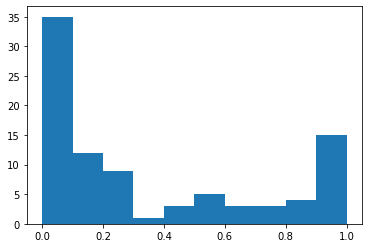

In [67]:
plt.hist(scores)